In [1]:
#######
IN_DATA_FNAMES = ['/oak/stanford/orgs/kipac/users/delon/LensQuEst/map_sims_800x800_20x20_%d.pkl'%(i) for i in range(1,51)]
import warnings
warnings.filterwarnings("ignore")
#####

In [2]:
import os, sys
WORKING_DIR = os.path.dirname(os.path.abspath(''))
sys.path.insert(1, os.path.join(WORKING_DIR,'LensQuEst'))

In [3]:
from universe import *
from halo_fit import *
from cmb import *
from flat_map import *
from weight import *
from pn_2d import *
import pickle
import seaborn as sns
from scipy.stats import spearmanr
import matplotlib
from tqdm import trange, tqdm

In [4]:
# in_data = {}

# for fname in tqdm(IN_DATA_FNAMES):
#     f = open(fname, 'rb') 
#     c_in_data = pickle.load(f) 
#     f.close()
#     for key in c_in_data:
#         if(key not in in_data.keys()):
#             in_data[key] = np.array(c_in_data[key])
#         else:
#             in_data[key] = np.vstack( (in_data[key],np.array(c_in_data[key])) )


# for key in in_data:
#     print(key, np.shape(in_data[key]))

In [5]:
print("Map properties")

# number of pixels for the flat map
nX = 800
nY =800

# map dimensions in degrees
sizeX = 20.
sizeY = 20.

# basic map object
baseMap = FlatMap(nX=nX, nY=nY, sizeX=sizeX*np.pi/180., sizeY=sizeY*np.pi/180.)

# multipoles to include in the lensing reconstruction
lMin = 30.; lMax = 3.5e3

# ell bins for power spectra
lRange = (1., 2.*lMax)  # range for power spectra

Map properties


In [6]:
oup_fname = '../data/input/universe_Planck15/camb/CAMB_outputs.pkl'
print(oup_fname)
f = open(oup_fname, 'rb') 
powers,cl,c_lensed,c_lens_response = pickle.load(f)
f.close()

../data/input/universe_Planck15/camb/CAMB_outputs.pkl


In [7]:
print("CMB experiment properties")

# Adjust the lMin and lMax to the assumptions of the analysis
# CMB S3 specs
cmb = StageIVCMB(beam=1.4, noise=7., lMin=lMin, lMaxT=lMax, lMaxP=lMax, atm=False)

CMB experiment properties


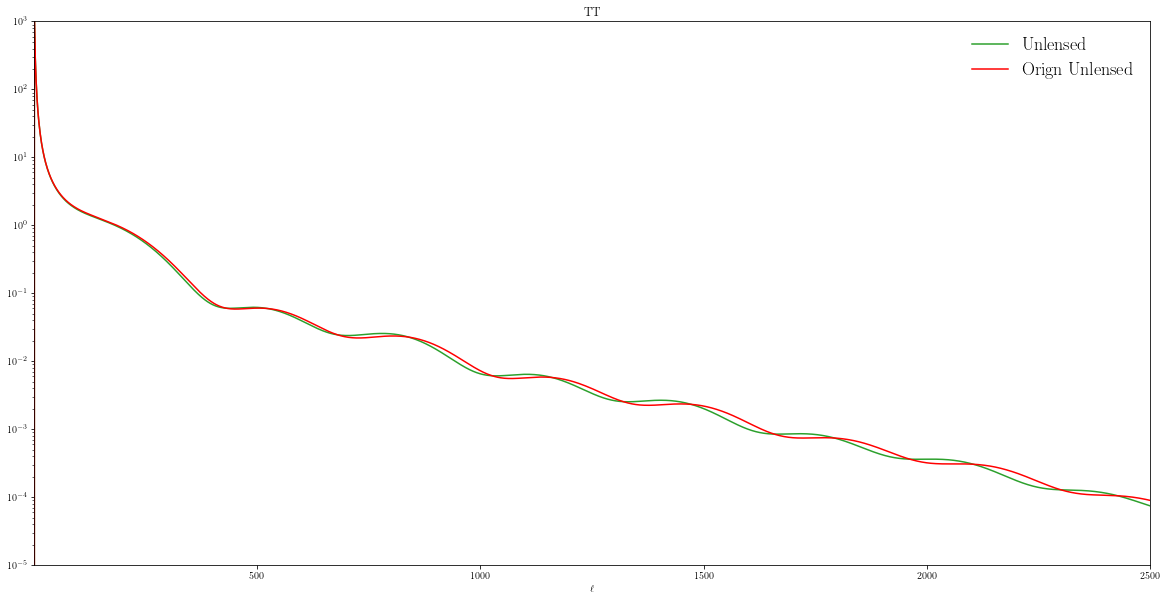

In [8]:
#plot the total lensed CMB power spectra versus unlensed, and fractional difference
totCL=powers['total']
unlensedCL=powers['unlensed_scalar']
#Python CL arrays are all zero based (starting at L=0), Note L=0,1 entries will be zero by default.
#The different CL are always in the order TT, EE, BB, TE (with BB=0 for unlensed scalar results).
plt.figure(figsize=(20,10))
ls = np.arange(totCL.shape[0])


origTT = list(map(cmb.funlensedTT, ls))


ls2 = np.arange(2,3501)
# plt.plot(ls2, (c_lensed[2:3501,0])/(ls2*(ls2+1)/(2*np.pi)), color='b', label='Lensed clensed')
# plt.scatter(ls,totCL[:,0]/(ls*(ls+1)/(2*np.pi)), color='k', s=5, label='Lensed')

plt.plot(ls,unlensedCL[:,0]/(ls*(ls+1)/(2*np.pi)), color='C2', label='Unlensed')
plt.plot(ls,origTT, color='r', label='Orign Unlensed')

plt.title('TT')

plt.xlim([2,2500])
plt.ylim([1e-5, 1e3])
plt.legend(frameon=False)
plt.xlabel(r'$\ell$');
plt.yscale('log')

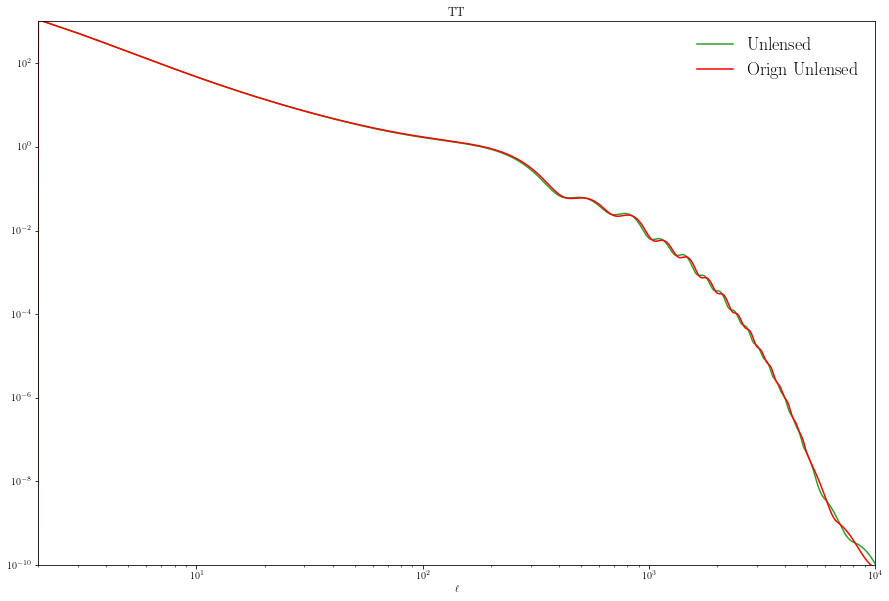

In [23]:
#plot the total lensed CMB power spectra versus unlensed, and fractional difference
totCL=powers['total']
unlensedCL=powers['unlensed_scalar']
#Python CL arrays are all zero based (starting at L=0), Note L=0,1 entries will be zero by default.
#The different CL are always in the order TT, EE, BB, TE (with BB=0 for unlensed scalar results).
plt.figure(figsize=(15,10))
ls = np.arange(totCL.shape[0])


origTT = list(map(cmb.funlensedTT, ls))


ls2 = np.arange(2,3501)
# plt.plot(ls2, (c_lensed[2:3501,0])/(ls2*(ls2+1)/(2*np.pi)), color='b', label='Lensed clensed')
# plt.plot(ls,totCL[:,0]*ls**4, color='k', label='Lensed')

plt.plot(ls,unlensedCL[:,0]/(ls*(ls+1))*2*np.pi, color='C2', label='Unlensed')
plt.plot(ls,origTT, color='r', label='Orign Unlensed')

plt.title('TT')

plt.xlim([2,10000])
plt.ylim([1e-10, 1e3])
plt.legend(frameon=False)
plt.xlabel(r'$\ell$');
plt.yscale('log')
plt.xscale('log')

In [10]:
print("CMB lensing power spectrum")
u = UnivPlanck15()
halofit = Halofit(u, save=False)
w_cmblens = WeightLensSingle(u, z_source=1100., name="cmblens")
p2d_cmblens = P2dAuto(u, halofit, w_cmblens, save=False)

CMB lensing power spectrum


(2, 30000)

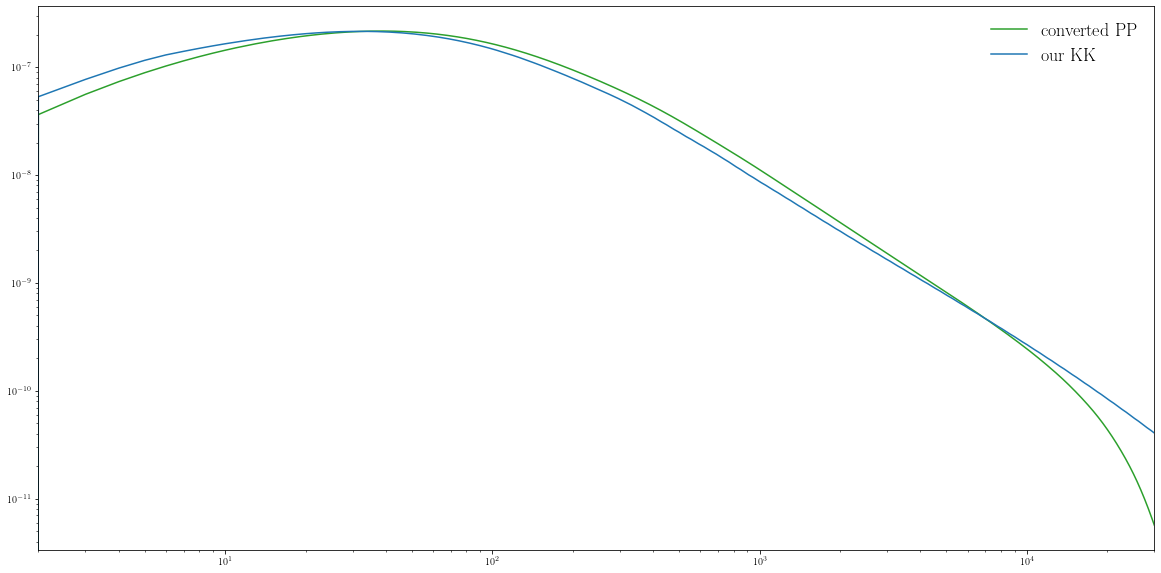

In [11]:
ls = np.arange(cl.shape[0])

plt.figure(figsize=(20,10))
PP = cl[:,0]
rawPP = PP*2*np.pi/((ls*(ls+1))**2)
rawKK = ls**4/4 * rawPP

plt.plot(ls, rawKK, color='C2', label='converted PP')

kk_ours = np.array(list(map(p2d_cmblens.fPinterp, ls)))

# plt.plot(ls, kk_ours*(ls*(ls+1))**2/(2*np.pi)*4/ls**4, label='our KK converted to phi phi')
plt.plot(ls, kk_ours, label='our KK')

plt.xscale('log')
plt.yscale('log')
plt.legend(frameon=False)
plt.xlim([2,np.max(ls)])

In [49]:
L = np.arange(unlensedCL.shape[0])

unlensedTT = unlensedCL[:,0]/(L*(L+1))*2*np.pi
F = unlensedTT
funlensedTT = interp1d(L, F, kind='linear', bounds_error=False, fill_value=0.)

L = np.arange(cl.shape[0])
PP = cl[:,0]
rawPP = PP*2*np.pi/((L*(L+1))**2)
rawKK = L**4/4 * rawPP

fKK = interp1d(L, rawKK, kind='linear', bounds_error=False, fill_value=0.)

L = np.arange(totCL.shape[0])

lensedTT = totCL[:,0]/(L*(L+1))*2*np.pi
F = lensedTT
flensedTT = interp1d(L, F, kind='linear', bounds_error=False, fill_value=0.)

In [39]:
cmb0Fourier = baseMap.genGRF(funlensedTT, test=False)
cmb0 = baseMap.inverseFourier(cmb0Fourier)


kCmbFourier = baseMap.genGRF(fKK, test=False)
kCmb = baseMap.inverseFourier(kCmbFourier)

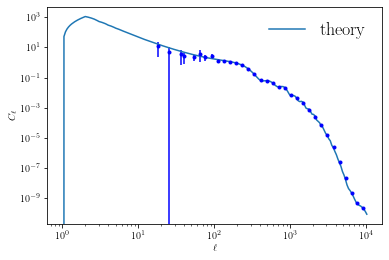

In [41]:
baseMap.powerSpectrum(cmb0Fourier, plot=True, theory=[funlensedTT]);

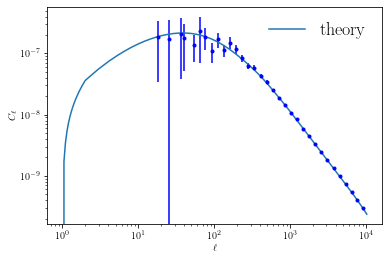

In [40]:
baseMap.powerSpectrum(kCmbFourier, plot=True, theory=[fKK]);

In [42]:
lensedCmb = baseMap.doLensing(cmb0, kappaFourier=kCmbFourier)
lensedCmbFourier = baseMap.fourier(lensedCmb)

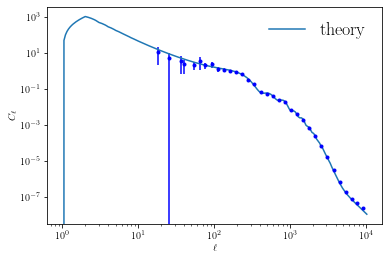

In [47]:
baseMap.powerSpectrum(lensedCmbFourier, plot=True, theory=[flensedTT]);

In [50]:
fgFourier = baseMap.genGRF(cmb.fForeground, test=False)
lensedCmbFourier = lensedCmbFourier + fgFourier
lensedCmb = baseMap.inverseFourier(lensedCmbFourier)

noiseFourier = baseMap.genGRF(cmb.fdetectorNoise, test=False)
totalCmbFourier = lensedCmbFourier + noiseFourier
totalCmb = baseMap.inverseFourier(totalCmbFourier)

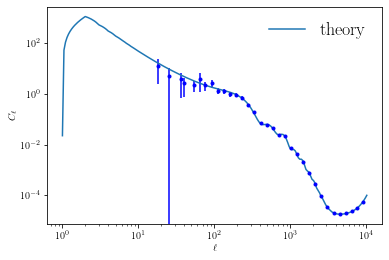

(array([1.10134950e+00, 1.32459194e+00, 1.59308540e+00, 1.91600222e+00,
        2.30437396e+00, 2.77146825e+00, 3.33324210e+00, 4.00888694e+00,
        4.82148431e+00, 5.79879436e+00, 6.97420418e+00, 8.38786839e+00,
        1.00880809e+01, 1.21329248e+01, 1.45922566e+01, 1.80000000e+01,
        2.11074786e+01, 2.54558441e+01, 3.05316487e+01, 3.60000000e+01,
        4.02492236e+01, 5.46119298e+01, 6.48999230e+01, 7.59686507e+01,
        9.23240847e+01, 1.11392712e+02, 1.35796705e+02, 1.61112716e+02,
        1.93604685e+02, 2.33437499e+02, 2.78217850e+02, 3.36081721e+02,
        4.06007460e+02, 4.87720155e+02, 5.87025726e+02, 7.05868439e+02,
        8.48636506e+02, 1.02092252e+03, 1.22775430e+03, 1.47687985e+03,
        1.77622062e+03, 2.13575670e+03, 2.56875901e+03, 3.08927265e+03,
        3.71521993e+03, 4.46882622e+03, 5.37502335e+03, 6.46445903e+03,
        7.62329283e+03, 9.02701246e+03]),
 array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00

In [53]:
ftot = lambda l : flensedTT(l) + cmb.fForeground(l) + cmb.fdetectorNoise(l)
baseMap.powerSpectrum(totalCmbFourier, plot=True, theory=[ftot])